In [16]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import shap

train_path = "../02_Data/Processed/sp500_tabular_train.csv"
val_path = "../02_Data/Processed/sp500_tabular_val.csv"
test_path = "../02_Data/Processed/sp500_tabular_test.csv"

df_train = pd.read_csv(train_path, parse_dates=["Date"])
df_val = pd.read_csv(val_path, parse_dates=["Date"])
df_test = pd.read_csv(test_path, parse_dates=["Date"])

target_col = "target_next_return"
exclude_cols = ["Date", target_col]

feature_cols = [c for c in df_train.columns if c not in exclude_cols]

X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

X_val = df_val[feature_cols].values
y_val = df_val[target_col].values

X_test = df_test[feature_cols].values
y_test = df_test[target_col].values

print("Number of features:", len(feature_cols))
print("First features:", feature_cols[:10])
print("Has vix_level:", "vix_level" in feature_cols)


Number of features: 14
First features: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'ma_5', 'ma_20', 'rolling_vol_20', 'sentiment_mean']
Has vix_level: True


In [17]:
target_col = "target_next_return"

exclude_cols = ["Date", target_col]

feature_cols = [c for c in df_train.columns if c not in exclude_cols]
print("Number of features:", len(feature_cols))
print("First features:", feature_cols[:10])

X_train = df_train[feature_cols].values
y_train = df_train[target_col].values

X_val = df_val[feature_cols].values
y_val = df_val[target_col].values

X_test = df_test[feature_cols].values
y_test = df_test[target_col].values


Number of features: 14
First features: ['Close', 'High', 'Low', 'Open', 'Volume', 'log_return', 'ma_5', 'ma_20', 'rolling_vol_20', 'sentiment_mean']


In [18]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)

def regression_summary(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)
    mask = sign_true != 0
    dir_acc = float(np.mean(sign_true[mask] == sign_pred[mask]))
    print(f"{label}  mae={mae:.6f}  rmse={rmse:.6f}  dir_acc={dir_acc:.3f}")

y_val_pred = rf.predict(X_val)
y_test_pred = rf.predict(X_test)

regression_summary(y_val, y_val_pred, "Validation")
regression_summary(y_test, y_test_pred, "Test")


Validation  mae=0.006466  rmse=0.008265  dir_acc=0.552
Test  mae=0.007306  rmse=0.011049  dir_acc=0.435


In [19]:
import shap

explainer = shap.TreeExplainer(rf)

# sample at most 500 rows from val for SHAP speed
X_val_sample = X_val[:500]
shap_values = explainer.shap_values(X_val_sample)

shap_values.shape


(250, 14)

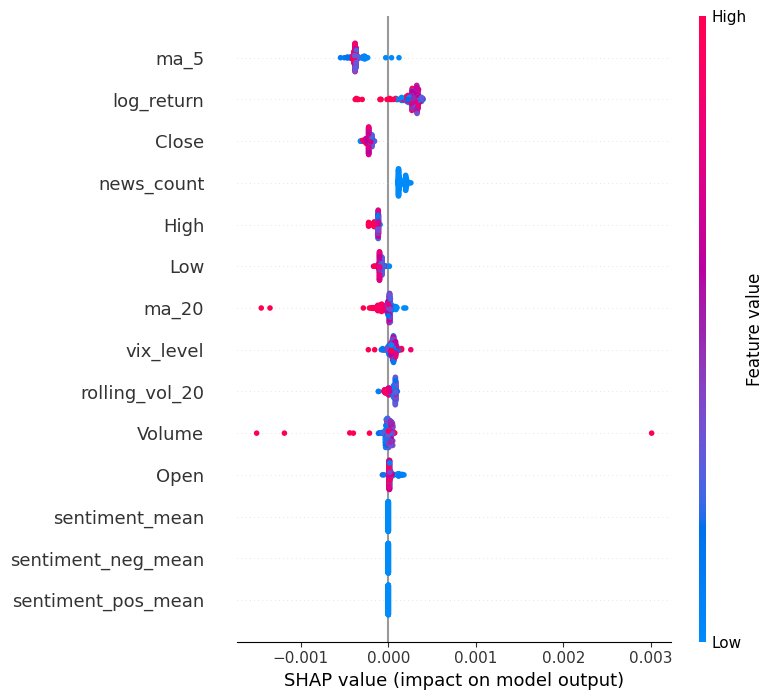

In [20]:
shap.summary_plot(shap_values, X_val_sample, feature_names=feature_cols)


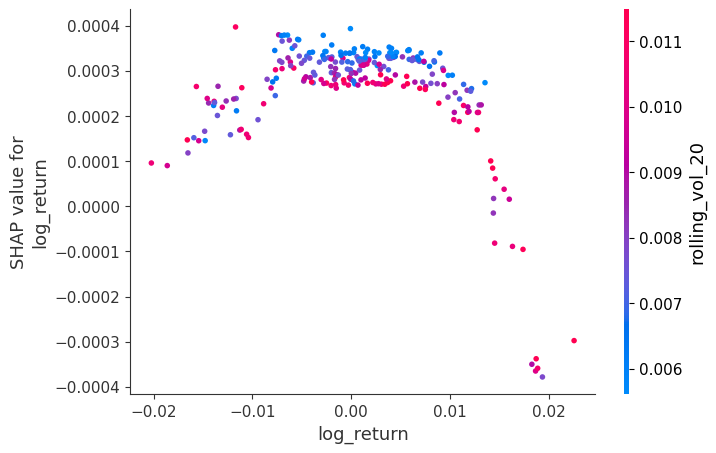

In [21]:
shap.dependence_plot(
    "log_return",
    shap_values,
    X_val_sample,
    feature_names=feature_cols,
)


In [22]:
import numpy as np
from pathlib import Path

output_dir = Path("../02_Data/Processed")
output_dir.mkdir(parents=True, exist_ok=True)

np.savez_compressed(
    output_dir / "rf_shap_val_sample.npz",
    X_val_sample=X_val_sample,
    shap_values=shap_values,
    feature_names=np.array(feature_cols),
)


In [23]:
import pandas as pd
import numpy as np

abs_mean_importance = np.mean(np.abs(shap_values), axis=0)

df_global_importance = pd.DataFrame(
    {
        "feature": feature_cols,
        "mean_abs_shap": abs_mean_importance,
    }
).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

df_global_importance.head(20)



,feature,mean_abs_shap
0,ma_5,0.000366
1,log_return,0.000283
2,Close,0.000219
3,news_count,0.000152
4,High,0.000123
5,Low,0.000089
6,ma_20,0.000058
7,vix_level,0.000057
8,rolling_vol_20,0.000053
9,Volume,0.000046


In [24]:
results_dir = Path("../05_Results")
results_dir.mkdir(parents=True, exist_ok=True)

global_importance_path = results_dir / "rf_shap_global_importance.csv"
df_global_importance.to_csv(global_importance_path, index=False)
global_importance_path


WindowsPath('../05_Results/rf_shap_global_importance.csv')

In [25]:
# Pick a single validation example to explain
idx = len(df_val) - 1  # for example

x_single = X_val[idx : idx + 1]
y_true_single = y_val[idx]
y_pred_single = rf.predict(x_single)[0]
date_single = df_val.iloc[idx]["Date"]

explainer = shap.TreeExplainer(rf)
shap_single = explainer.shap_values(x_single)[0]

df_local = pd.DataFrame(
    {
        "feature": feature_cols,
        "value": x_single[0],
        "shap_value": shap_single,
    }
).sort_values("shap_value", ascending=False).reset_index(drop=True)

df_local.head(15)


,feature,value,shap_value
0,log_return,-2.830477e-03,0.000379
1,news_count,0.000000e+00,0.000107
2,Open,4.782880e+03,0.000044
3,sentiment_neg_mean,0.000000e+00,0.000000
4,sentiment_mean,0.000000e+00,0.000000
5,sentiment_pos_mean,0.000000e+00,0.000000
6,Volume,3.126060e+09,-0.000002
7,vix_level,1.245000e+01,-0.000012
8,rolling_vol_20,6.077964e-03,-0.000109
9,Low,4.751990e+03,-0.000113


In [26]:
shap_single = explainer.shap_values(x_single)  # shape (1, num_features)
shap_single = shap_single[0]

df_local = pd.DataFrame(
    {
        "feature": feature_cols,
        "value": x_single[0],
        "shap_value": shap_single,
    }
).sort_values("shap_value", ascending=False).reset_index(drop=True)

df_local.head(15)


,feature,value,shap_value
0,log_return,-2.830477e-03,0.000379
1,news_count,0.000000e+00,0.000107
2,Open,4.782880e+03,0.000044
3,sentiment_neg_mean,0.000000e+00,0.000000
4,sentiment_mean,0.000000e+00,0.000000
5,sentiment_pos_mean,0.000000e+00,0.000000
6,Volume,3.126060e+09,-0.000002
7,vix_level,1.245000e+01,-0.000012
8,rolling_vol_20,6.077964e-03,-0.000109
9,Low,4.751990e+03,-0.000113


In [27]:
local_path = results_dir / "rf_shap_example_local_explanation.csv"
df_local.to_csv(local_path, index=False)
local_path


WindowsPath('../05_Results/rf_shap_example_local_explanation.csv')

In [28]:
shap.initjs()
shap.force_plot(
    explainer.expected_value,
    shap_single,
    x_single,
    feature_names=feature_cols,
)


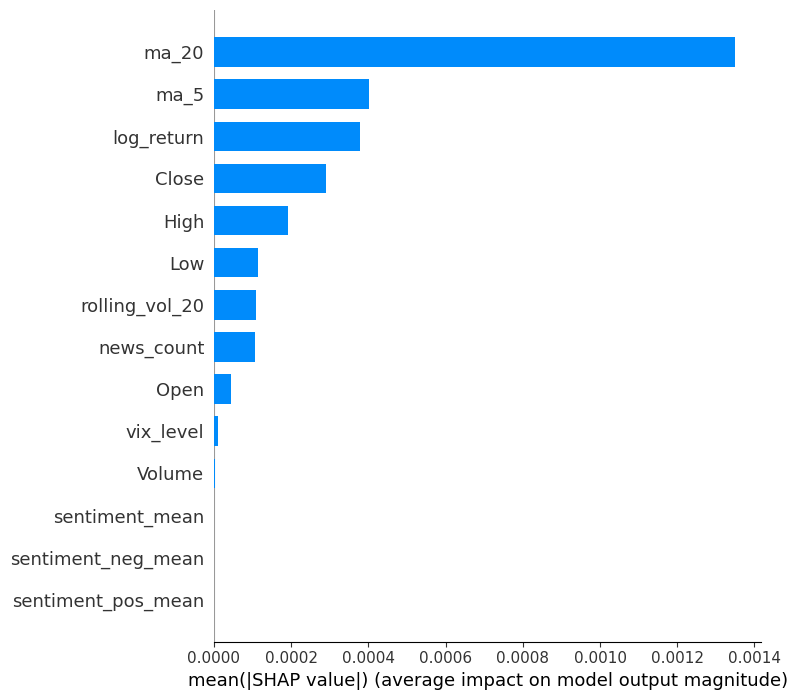

In [29]:
shap.summary_plot(
    shap_single.reshape(1, -1),
    x_single,
    feature_names=feature_cols,
    plot_type="bar",
)
